# Imputing

Let's impute the missingness away!

In this Notebook we will have a look at various imputation methods and compare their results and performances.  
Compared imputation methods:
 + LOCF (last observed carried forward)
 + NOCB (next observation carried backward)
 + Mean imputation
 + Median imputation
 + BRITS (Single imputation)
 + SAITS (Single imputation)
 + mTAN (Multiple imputation)


In [1]:
%load_ext autoreload
%autoreload 2

from toy_dataset import data_utils
from imputation.models.mTAN import utils
import matplotlib.pyplot as plt
import numpy as np                      

# Load Dataset

Here we create mcar missingness.


In [2]:
name = 'toydataset_50000'
path = data_utils.datasets_dict[name]
dataset = data_utils.ToyDataDf(path)
dataset.create_mcar_missingness(0.5)

error_dict = dict()
# The missingness ratios to be evaluated
missingness = np.linspace(0.1,0.9,9)
# How many times should the imputation be repeated (and then take average)
repeat_imputation = 1

--
Created MCAR missing data, but without missingness in columns Index(['id', 'time'], dtype='object')
missingness_rate: 0.5,	missingness_value: nan
Missing values: 250000 out of 500000 (50.0%) (!excluding aforementioned columns)
Data values in entire dataframe is 750000 (shape: (125000, 6))


In [5]:
dataset.df.shape
dataset.df.mean(numeric_only=True)
dataset.df.median(numeric_only=True)

time              24.500000
Noise              0.462838
Trend              0.429122
Seasonality        0.505597
Trend + Season     0.415462
dtype: float64

# Simple Imputations
 
Next we are looking at these basic imputation methods.

+ Mean
+ Median
+ LOCF
+ NOCB

As the data in a time series can be subject to different phenomena, the different basic imputation methods perform different depending on the phenomena. These phenomena can be:  

+ no trend or seasonality (fig1)
+ has trend, but no seasonality (fig2)
+ has seasonality, but no trend (fig3)
+ has both trend and seasonality (fig4)

<center>
    <img src="../figures/time_series_example.png" alt="" style="width:500px;height:350px;"> 
    <br>
    Image inspired from <a href="https://www.kaggle.com/code/juejuewang/handle-missing-values-in-time-series-for-beginners/report">Kaggle</a>.

</center>




### Mean Imputation

The dataset is a collection of many individual time series, which can potentially have different lengths. Missing values are filled with the mean of the *corresponding time series*.

In [8]:
name = 'mean'
df_mis = dataset.impute_mean()
mse = dataset.mse(df_mis)
error_dict[name] = mse

In [13]:
name = 'mean'
impute_func = dataset.impute_mean
error_dict = dataset.get_mse_impute(name, error_dict, impute_func, missingness, repeat_imputation)

Missingness rate: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


### Median Imputation

Same as for Mean Imputation, the mean is calculated for each time series.

In [14]:
name = 'median'
impute_func = dataset.impute_median
error_dict = dataset.get_mse_impute(name, error_dict, impute_func, missingness, repeat_imputation)

Missingness rate: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


### LOCF Imputation

In [15]:
name = 'LOCF'
impute_func = dataset.impute_LOCF
error_dict = dataset.get_mse_impute(name, error_dict, impute_func, missingness, repeat_imputation)

Missingness rate: 100%|██████████| 9/9 [00:42<00:00,  4.68s/it]


### NOCB Imputation

In [16]:
name = 'NOCB'
impute_func = dataset.impute_NOCB
error_dict = dataset.get_mse_impute(name, error_dict, impute_func, missingness, repeat_imputation)

Missingness rate: 100%|██████████| 9/9 [00:43<00:00,  4.79s/it]


# More sophisticated Imputation methods

Let us look at more sophisticated imputation methods, such as Single Imputation methods, that try to approximate the conditional mean: 

$$\mathbb{E} [ ~ p(X_\text{miss} | X_\text{obs}, \theta) ~ ]  \qquad \leftarrow \text{Cond. mean} \quad$$ 

On the other hand we also look at a Multiple Imputation method, that does not try to approximate the conditional mean, but the entire probability density function:

$$X_\text{miss} \sim ~ p(X_\text{miss} | X_\text{obs}, \theta)$$

When using the multiple imputation method we can obtain the mean by sampling a few times and and averaging the results.


## Single Imputation

We look at the following Single Imputation methods:

+ SAITS
+ BRITS

### SAITS

In [ ]:
name = 'SAITS'
impute_func = dataset.impute_SAITS
error_dict = dataset.get_mse_impute(name, error_dict, impute_func, missingness, repeat_imputation)

100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


### BRITS

In [41]:
name = 'BRITS'
impute_func = dataset.impute_BRITS
error_dict = dataset.get_mse_impute(name, error_dict, impute_func, missingness, repeat_imputation)

100%|██████████| 9/9 [00:23<00:00,  2.61s/it]


# Multiple Imputation - mTAN

We will look at the **mTAN** imputation.

In [3]:
name = 'mTAN'
# model_args='--niters 100 --lr 0.001 --batch-size 128 --rec-hidden 32 --latent-dim 8 --length 40 --enc mtan_rnn --dec mtan_rnn --gen-hidden 50 --save 0 --k-iwae 5 --std 0.01 --norm --learn-emb --kl --seed 3 --num-ref-points 40 --dataset toy'.split()
model_args = '--niters 100 --lr 0.001 --batch-size 128 --rec-hidden 256 --latent-dim 8 --length 40 --enc mtan_rnn --dec mtan_rnn --gen-hidden 256 --save 1 --k-iwae 10 --std 0.01 --norm --learn-emb --kl --seed 0 --num-ref-points 40 --dataset toy'.split()
train_dataloader, validation_dataloader = dataset.prepare_mtan(model_args=model_args, batch_size=100)
# dataset.mtan.parse_arguments(model_args=model_args)
path_checkpoint = '/home2/joshua.wendland/Documents/sepsis/imputation/runs/mTANtoy/2022.12.17-14.12.20/toy_mtan_rnn_mtan_rnn.h5'
dataset.mtan.load_from_checkpoint(path_checkpoint)

parameters encoder/decoder: 851554 730366
Loading saved weights done. Model trained until epoch  10


In [4]:
dataset.train_mtan( train_dataloader, validation_dataloader, epochs=10)

Begin training! Training until epoch 20.
Iter: 11, avg elbo: 20.3460, avg reconst: 20.8084, avg kl: 2.2330, mse: 0.004555, kl_coef: 0.61
Iter: 12, avg elbo: 19.7055, avg reconst: 20.1763, avg kl: 2.1867, mse: 0.004416, kl_coef: 0.65
Iter: 13, avg elbo: 18.7915, avg reconst: 19.3673, avg kl: 2.1303, mse: 0.004232, kl_coef: 0.69
Iter: 14, avg elbo: 18.1775, avg reconst: 18.7197, avg kl: 2.0962, mse: 0.004097, kl_coef: 0.72
Iter: 15, avg elbo: 17.6789, avg reconst: 18.2121, avg kl: 2.0345, mse: 0.003992, kl_coef: 0.75
Iter: 16, avg elbo: 17.2345, avg reconst: 17.8029, avg kl: 1.9990, mse: 0.003903, kl_coef: 0.77
Iter: 17, avg elbo: 16.8691, avg reconst: 17.3919, avg kl: 1.9712, mse: 0.003819, kl_coef: 0.79
Iter: 18, avg elbo: 16.3863, avg reconst: 16.9332, avg kl: 1.9556, mse: 0.003719, kl_coef: 0.81
Iter: 19, avg elbo: 16.1613, avg reconst: 16.6980, avg kl: 1.9272, mse: 0.003670, kl_coef: 0.83
Iter: 20, avg elbo: 16.1719, avg reconst: 16.8048, avg kl: 1.8838, mse: 0.003681, kl_coef: 0.85

In [65]:
import torch
torch.cuda.empty_cache()

# Visualize results


In [42]:
error_dict['mTAN'] =  [0.43174353,0.4409736, 0.4478371, 0.45952868,0.55937785,0.559954, 0.5702916,0.61676675,0.7723941] 

mean
median
LOCF
NOCB


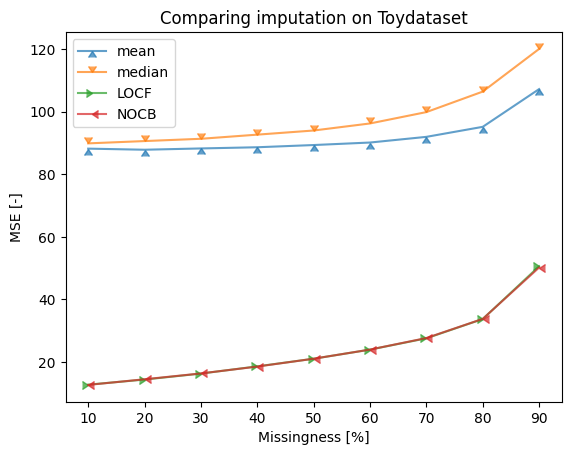

In [17]:
fig = plt.figure()
plt.title(f'Comparing imputation on {dataset.name}')
plt.ylabel('MSE [-]')
plt.xlabel('Missingness [%]')
markers = [6,7,5,4,8,9]
for key, marker in zip(error_dict.keys(), markers):
    print(key)
    plt.plot(missingness*100, error_dict[key], alpha=0.7, marker=marker, ms=6, label=key)
plt.legend(loc='best')
plt.show()


# Visualize some time series in order to see imputation

In [5]:
imputed, X_intact, X, indicating_mask = dataset.impute_SAITS(missingness_rate=0.4)


No given device, using default device: cuda:0
Model initialized successfully. Number of the trainable parameters: 1324864
epoch 0: training loss 1.3342
epoch 1: training loss 2.1910
epoch 2: training loss 1.6702
epoch 3: training loss 1.4025
epoch 4: training loss 1.3077
epoch 5: training loss 1.2872
epoch 6: training loss 1.2977
epoch 7: training loss 1.2276
epoch 8: training loss 1.2378
epoch 9: training loss 1.1119
epoch 10: training loss 1.0648
epoch 11: training loss 1.1161
epoch 12: training loss 1.1009
epoch 13: training loss 1.0837
epoch 14: training loss 1.0285
epoch 15: training loss 1.0174
epoch 16: training loss 1.0248
epoch 17: training loss 1.0221
epoch 18: training loss 1.0030
epoch 19: training loss 0.9778
epoch 20: training loss 0.9582
epoch 21: training loss 0.9440
epoch 22: training loss 0.9508
epoch 23: training loss 0.9741
epoch 24: training loss 0.9339
epoch 25: training loss 0.9172
epoch 26: training loss 0.9543
epoch 27: training loss 0.9474
epoch 28: training l

# Visualize some imputation results

Here we look at a single time series id and visualize a variable of it.
We need to:  
+ Get the data
+ Perform single imputation directly
+ Train the deep models
+ Perform imputation with deep models
+ Plot imputations, plot training and ground truth

In [9]:
feature_index = 3
sample = 10
dataset.create_mcar_missingness(0.3)
X_intact, X, ind_mask, time_pts, id = dataset.get_sample(sample)
print(id)

--
Created MCAR missing data, but without missingness in columns Index(['id', 'time'], dtype='object')
missingness_rate: 0.3,	missingness_value: nan
Missing values: 1200000 out of 4000000 (30.0%) (!excluding aforementioned columns)
Data values in entire dataframe is 6000000 (shape: (1000000, 6))
id_10005


id_10005


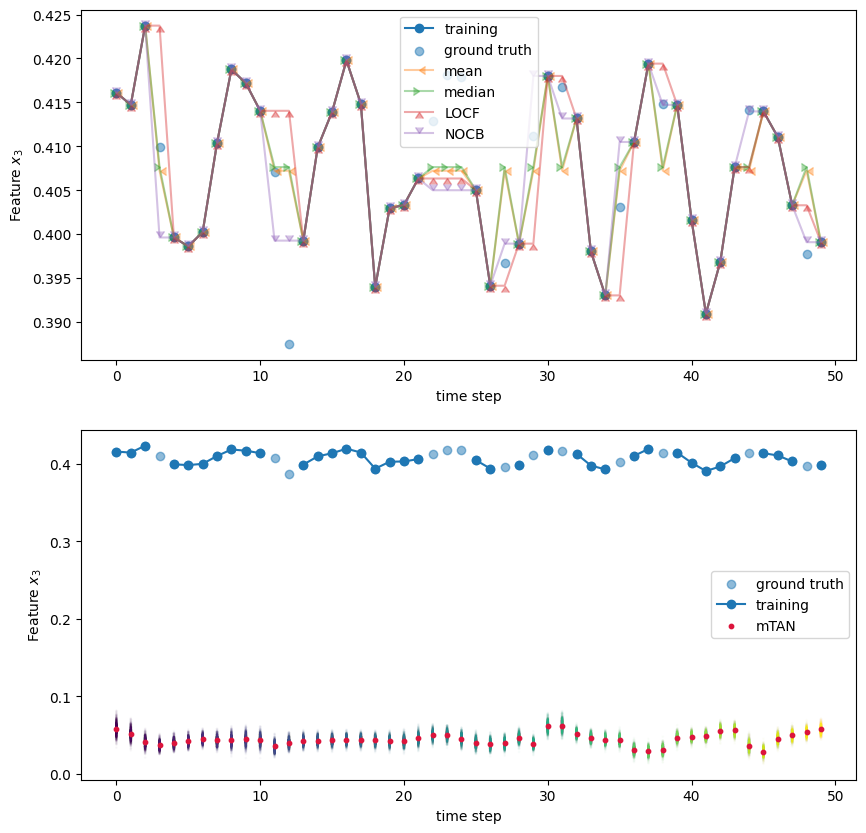

In [10]:
""" --- SIMPLE IMPUTATION --- """
feature = feature_index + 2 # because simple imputation also has columns ['id', 'time']
# dataset.create_mcar_missingness(0.3)
X_intact, X, indicating_mask = dataset.get_missingness_data()
X = dataset.df_mis
# imputed, X_intact, X, indicating_mask
fig = plt.figure(figsize=(10,10))
fig.add_subplot(211)
id = dataset.df['id'].unique()[sample]
print(id)

y = X.loc[X['id']==id].iloc[:, feature]
time_labels = np.arange(len(y))
plt.plot(time_labels, y, marker='o', label='training')
y = X_intact.loc[X_intact['id']==id].iloc[:, feature]
plt.scatter(time_labels, y, marker='o', alpha=0.5, label='ground truth')

imp_functions = [dataset.impute_mean, dataset.impute_median, dataset.impute_LOCF, dataset.impute_NOCB]
# imp_functions = [dataset.impute_mean]
imp_names = ['mean', 'median', 'LOCF', 'NOCB']
markers = ['v', '^', '<', '>']
markers = [4,5,6,7]
for imputation_func, name, marker in zip(imp_functions, imp_names, markers):
    imputed = imputation_func(X)
    # imputed = X.fillna(value=X.groupby('id').transform('fillna', method='ffill'))
    imputed = imputed.loc[imputed['id']==id]
    # imputed = imputed.iloc[:,2:]
    imputed = imputed.to_numpy()
    plt.plot(time_labels, imputed[:, feature], marker=marker, alpha=0.4, label=name)
    
plt.ylabel(f'Feature $x_{feature_index}$')
plt.xlabel('time step')
plt.legend()

#print(X.mean())

""" ########################################################################################"""
"""                            --- DEEP IMPUTATION ---                                      """
""" ########################################################################################"""

fig.add_subplot(212)
feature = feature_index 
X_intact, X, ind_mask, time_pts, id = dataset.get_sample(sample)
# mTAN
test_batch = dataset.mtan.combine_sample(X, ind_mask, time_pts)
test_batch = test_batch.unsqueeze(0)
pred_x = dataset.mtan.impute(test_batch, 1000, mean=False)
pred_x_mean = pred_x.mean(0).to('cpu').squeeze(0)

y = pred_x[:,0,:,feature].to('cpu')
# plt.plot(time_pts, pred_x_mean[:,feature], marker='o', ms=3, c='crimson', label='mTAN')
plt.scatter(time_pts, X_intact[:,feature], marker='o', alpha=0.5, label='ground truth')
plt.plot(time_pts, X[:,feature], marker='o', label='training')
# show PDF
for i in range(y.shape[0]):
    plt.scatter(time_pts, y[i,:], marker='.', alpha=0.02, s=4, c=time_pts, edgecolors=None, cmap='viridis', label='_mTAN PDF')
plt.scatter(time_pts, pred_x_mean[:,feature], marker='o', s=10, c='crimson', label='mTAN')
plt.legend(loc='best')
plt.ylabel(f'Feature $x_{feature_index}$')
plt.xlabel('time step')
plt.show()

In [3]:
model_args = '--niters 100 --lr 0.001 --batch-size 128 --rec-hidden 256 --latent-dim 32 --length 40 --enc mtan_rnn --dec mtan_rnn --gen-hidden 256 --save 1 --k-iwae 10 --std 0.01 --norm --learn-emb --kl --seed 0 --num-ref-points 40 --dataset toy'.split()
train_dataloader, validation_dataloader = dataset.prepare_mtan(model_args=model_args, batch_size=10)
# dataset.mtan.parse_arguments(model_args=model_args)
path_checkpoint = '/home2/joshua.wendland/Documents/sepsis/runs/mTANtoy/2022.12.19-11.01.28/toy_mtan_rnn_mtan_rnn.h5'
path_checkpoint = '/home2/joshua.wendland/Documents/sepsis/runs/mTANtoy/2022.12.20-16.47.36/toy_mtan_rnn_mtan_rnn.h5'
path_checkpoint = '/home2/joshua.wendland/Documents/sepsis/imputation/runs/mTANtoy/2022.12.17-14.12.20/toy_mtan_rnn_mtan_rnn.h5' # 100 iter model
path_checkpoint = '/home2/joshua.wendland/Documents/sepsis/imputation/runs/mTANtoy/2022.12.23-11.48.19/toy_mtan_rnn_mtan_rnn.h5' # 100 iter model
log_path = '/home2/joshua.wendland/Documents/sepsis/imputation/runs/mTANtoy/2022.12.23-11.48.19/'
dataset.mtan.load_from_checkpoint(path_checkpoint, log_path=log_path)

Using batch size 10 for training and validation set.
parameters encoder/decoder: 854002 767230
Logging and saving model to:  ./imputation/runs/mTANtoy/2022.12.28-13.04.58/

Loading model from  /home2/joshua.wendland/Documents/sepsis/imputation/runs/mTANtoy/2022.12.23-11.48.19/toy_mtan_rnn_mtan_rnn.h5
Loading saved weights done. Model trained until epoch  100
Logging and saving model to:  /home2/joshua.wendland/Documents/sepsis/imputation/runs/mTANtoy/2022.12.23-11.48.19/



Sample id: 1223
pred_x.shape: torch.Size([1, 50, 4])
observed.shape: torch.Size([1, 50, 4])
observed_data.shape: torch.Size([1, 50, 4])
mse: 0.009934826103399894


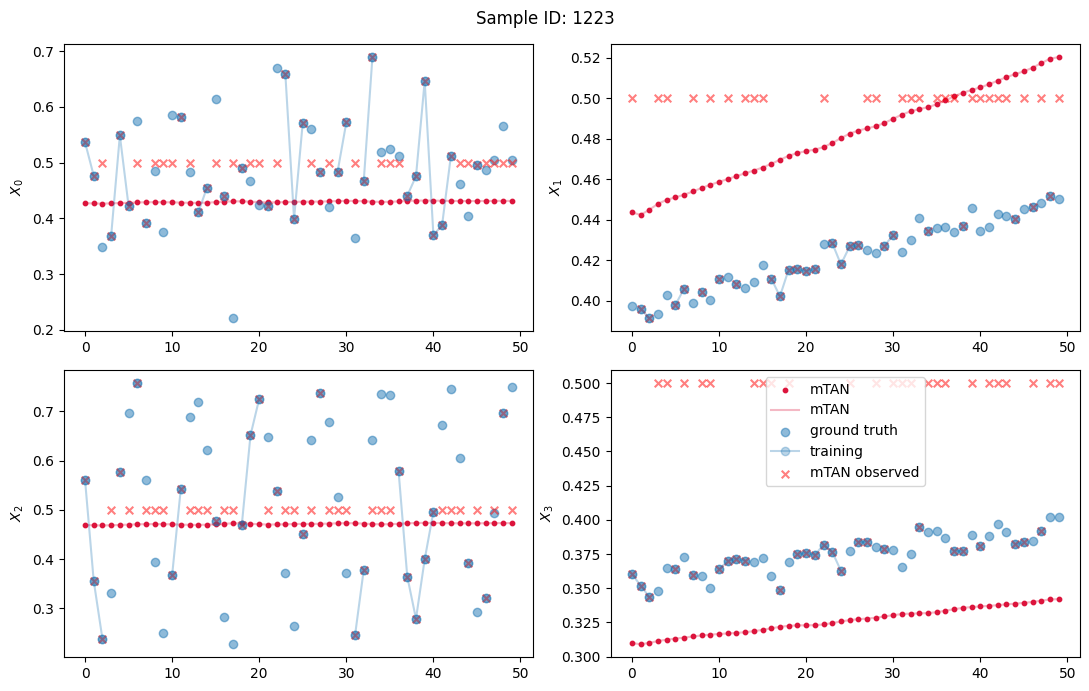

In [5]:
feature = feature_index  = 3
sample = np.random.randint(1,2500)
# sample = 1109
print(f'Sample id: {sample}')
X_intact, X, ind_mask, time_pts, id = dataset.get_sample(sample)
# ind_mask = (ind_mask==0)*1
# mTAN
test_batch = dataset.mtan.combine_sample(X, ind_mask, time_pts)
test_batch = test_batch.unsqueeze(0)
# test_batch[:, :, :4] = torch.from_numpy(X_intact) #inject fully observed data for inference
observed_data = test_batch[:, :, :4]
observed, pred_x = dataset.mtan.impute_new(test_batch, 100, mean=True)
pred_x_mean = pred_x.mean(0).to('cpu').squeeze(0)
print(f'pred_x.shape: {pred_x.shape}')
print(f'observed.shape: {observed.shape}')
print(f'observed_data.shape: {observed_data.shape}')
print(f'mse: {utils.mean_squared_error(np.nan_to_num(X, nan=0), pred_x_mean.numpy(), ind_mask)}')

fig = plt.figure(figsize=(11,7))
plt.suptitle(f'Sample ID: {sample}')
for i in range(4):
    fig.add_subplot(2,2,i+1)
    yy = pred_x_mean[:,i] 
    plt.scatter(time_pts, yy, marker='o', s=10, c='crimson', label='mTAN')
    plt.plot(time_pts, yy, alpha=0.3, c='crimson', label='mTAN')
    plt.scatter(time_pts, X_intact[:,i], marker='o', alpha=0.5, label='ground truth')
    plt.plot(time_pts, X[:,i], marker='o', alpha=0.3, label='training')
    plt.scatter(time_pts, observed[0,:,i].cpu(), c='red', alpha=0.5, marker='x', s=30, label='mTAN observed')
    # plt.scatter(time_pts, observed_data[0,:,i].cpu(), c='y', alpha=0.5, marker='D', label='true observed')
    plt.ylabel(f'$X_{i}$')
plt.legend()
plt.tight_layout()


### Compare MSE calculations (training vs inference)

In [6]:
from imputation.models.mTAN import utils
import matplotlib.pyplot as plt
from tqdm import tqdm

In [11]:
# training loop MSE
mtan = dataset.mtan
tl_mse = utils.evaluate(mtan.n_features, mtan.encoder, mtan.decoder, validation_dataloader, mtan.args)
print(tl_mse)

test_n: 2500.0
tensor(nan, device='cuda:0')


In [27]:
# manually loop
manual_mse = 0
batch_size = validation_dataloader.batch_size

for batch in tqdm(validation_dataloader):
    # preprocess data
    observed_data, observed_mask, observed_tp = mtan.split_sample(batch)
    observed_data = observed_data.cpu()
    observed_mask = observed_mask.cpu()
    # inference / prediction step
    pred_x = mtan.impute(batch, 10, mean=True)
    pred_x = pred_x.cpu()

    # compute mse
    mse = utils.mean_squared_error(observed_data.nan_to_num(0), pred_x, observed_mask)
    manual_mse += mse

    # print(observed_data[observed_mask==0])
    break

print('test_n:', (len(validation_dataloader) * batch_size))
manual_mse /= (len(validation_dataloader) * batch_size)
print('mse:', manual_mse)

  0%|          | 0/250 [00:00<?, ?it/s]

In [9]:
mse2 = 0

for sample in tqdm(range(len(dataset))):
    X_intact, X, ind_mask, time_pts, id = dataset.get_sample(sample)
    # ind_mask = (ind_mask==0)*1
    # mTAN
    test_batch = dataset.mtan.combine_sample(X, ind_mask, time_pts)
    test_batch = test_batch.unsqueeze(0)
    # test_batch[:, :, :4] = torch.from_numpy(X_intact) #inject fully observed data for inference
    observed_data = test_batch[:, :, :4]
    observed, pred_x = dataset.mtan.impute_new(test_batch, 2, mean=True)
    pred_x_mean = pred_x.mean(0).to('cpu').squeeze(0)

    mse2 += utils.mean_squared_error(np.nan_to_num(X, nan=0), pred_x_mean.numpy(), ind_mask)

mse2 /= len(dataset)
print(f'test_n: {len(dataset)}')
print(f'mse: {mse2}')

100%|██████████| 2500/2500 [00:38<00:00, 64.95it/s]

test_n: 2500
mse: 0.012422291036361374


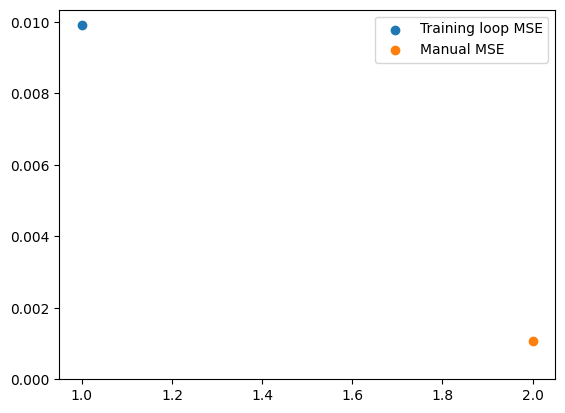

In [22]:
# visualize
fig = plt.figure()
plt.scatter(1, tl_mse.cpu(), label='Training loop MSE')
plt.scatter(2, manual_mse.cpu(), label='Manual MSE')
plt.legend()
plt.ylim((0,None))
plt.show()

### Impact of num. drawings $k$ on MSE 

When using the MSE (Mean Squared Error) metric we are optimizing for the conditional mean (?). A single draw from the latent space does not represent the conditional mean but is a draw from the conditional distribution. Hence, multiple draws and then averaging them would result in the conditional mean. This means the MSE should perform better the more samples are drawn from the latent distribution and averaged. This is what we look at here.

We perform the MSE calculation for each $k$ draws multiple time in order to receive the expected MSE depending on the number of draws.

$$\mathbb{E} [ ~ \text{MSE}(~ \mathbb{E}[~ x_\text{pred} ~]) ~|~ k ~ ]$$

In [8]:
from imputation.models.mTAN import utils
import torch 
from tqdm import tqdm

  0%|          | 0/10 [00:00<?, ?it/s]

(19,)


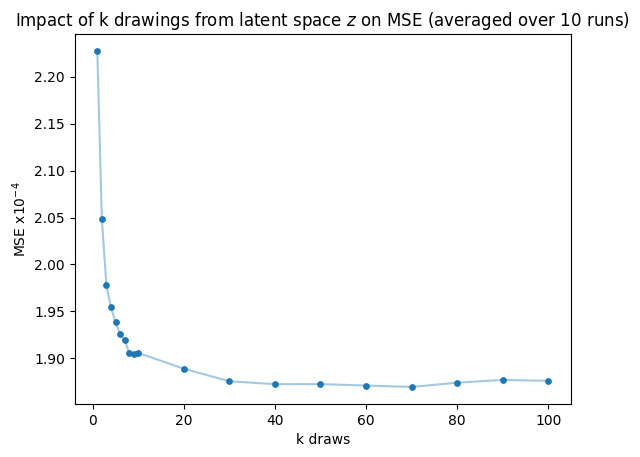

In [51]:

args = dataset.mtan.args
encoder = dataset.mtan.encoder
decoder = dataset.mtan.decoder
dim = dataset.mtan.n_features
validation_dataloader
k = np.concatenate((np.arange(1,10), np.arange(10,101, 10)))
k = torch.tensor(k).to(dataset.mtan.device)
mse = list()
repetitions = 10
# for each repition
for b in tqdm(range(repetitions)):
    temp_mse = list()
    # for each num drawings k
    for i in k:
        error = utils.evaluate(dim, encoder, decoder, validation_dataloader, args, i)
        temp_mse.append(error.cpu())
    mse.append(np.array(temp_mse))

# calculate mean 
mse = np.array(mse)
mse = mse.mean(axis=0)
# create figure
fig = plt.figure()
plt.xlabel('k draws')
plt.ylabel('MSE x$10^{-4}$')
plt.plot(k.cpu(), mse*1000, alpha=0.4)
plt.scatter(k.cpu(), mse*1000, s=15)
plt.title(f'Impact of k drawings from latent space $z$ on MSE (averaged over {repetitions} runs)')
plt.show()